# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [16]:
# import libraries
from pyspark.sql import SparkSession

In [17]:
# import libraries
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT

from functools import reduce

In [18]:
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [19]:
from pyspark.ml.tuning import CrossValidatorModel as mlm

In [20]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
df = spark.read.json('mini_sparkify_event_data.json')
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
pandas_df = df.toPandas()
pandas_df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [8]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286500 entries, 0 to 286499
Data columns (total 18 columns):
artist           228108 non-null object
auth             286500 non-null object
firstName        278154 non-null object
gender           278154 non-null object
itemInSession    286500 non-null int64
lastName         278154 non-null object
length           228108 non-null float64
level            286500 non-null object
location         278154 non-null object
method           286500 non-null object
page             286500 non-null object
registration     278154 non-null float64
sessionId        286500 non-null int64
song             228108 non-null object
status           286500 non-null int64
ts               286500 non-null int64
userAgent        278154 non-null object
userId           286500 non-null object
dtypes: float64(2), int64(4), object(12)
memory usage: 39.3+ MB


We can see from the above info that userID and sessionId have no null values, but it's possible that we have "blank" values, so we should check for those too.

In [9]:
pandas_df[pandas_df['userId'] == '']['userId'].count()

8346

The (arguably) cleanest way is to filter these out is to do it before we convert the loaded data into a pandas DataFrame.

In [10]:
# This comparison gave an error while in pandas, so we do it the spark DataFrame
df.filter(df.sessionId == '').count()

0

In [11]:
# Filter our DataFrame in exclude blank userId values
df = df.filter(df.userId != '')

# checking to see that we no longer have blank userId values
df.filter(df.userId == '').count()

0

In [12]:
# now we re-assign our pandas DataFrame variable with the filtered data

pandas_df = df.toPandas()

In [13]:
# performing the same check to see if it's consistent
pandas_df[pandas_df['userId'] == '']['userId'].count()

0

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [14]:
# We can see how many unique users and sessions we're working with
["Unique {}: {}".format(col, df.select(col).dropDuplicates().count()) for col in ('userId', 'sessionId')]

['Unique userId: 225', 'Unique sessionId: 2312']

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

We define churn as a label for users who cancel their account/subscription for this case. We can create a column for it in our data.

In [15]:
cancel_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

# apply churn column to data
df = df.withColumn("churn", cancel_flag("page"))

# Define window bounds
window_value = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

# Apply window
df = df.withColumn("churn", Fsum("churn").over(window_value))

In [16]:
# convert df to pandas for a nicer view of data head
pandas_df = df.toPandas()

In [17]:
pandas_df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Thumbs Up,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0


### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
# Count the number of users who churned and numebr who didn't.
df.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



We can examine the churn counts further by diving the groups by different demographics (gender, level, etc.) For now, we can look at gender as one demographic.

In [19]:
df.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     F|   84|
|    1|     M|   32|
|    1|     F|   20|
|    0|     M|   89|
+-----+------+-----+



Because reading numbers is often times difficult (especialyl when our tables get larger due to a larger number of partitions), we can create a function that will plot the columns we want.

In [20]:
def plot_demo_freq(subset, group, labels, X_label="# of Users", Y_label="Status"):
    ax = pandas_df.drop_duplicates(subset=subset).groupby(group)['userId'].count().plot(
                        kind="barh", figsize=(8,5),
                        title="# Unique users per category");
    ax.set_xlabel(X_label);
    ax.set_yticklabels(labels, rotation=0)
    ax.set_ylabel(Y_label);

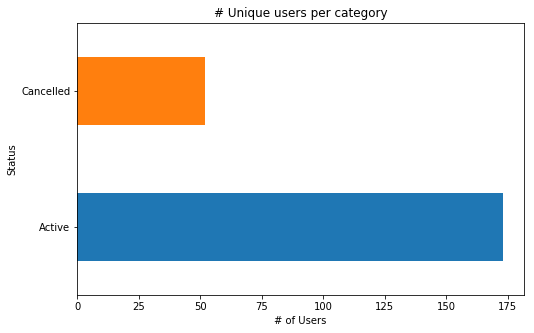

In [21]:
plot_demo_freq(['userId'], ['churn'], ['Active', 'Cancelled'])

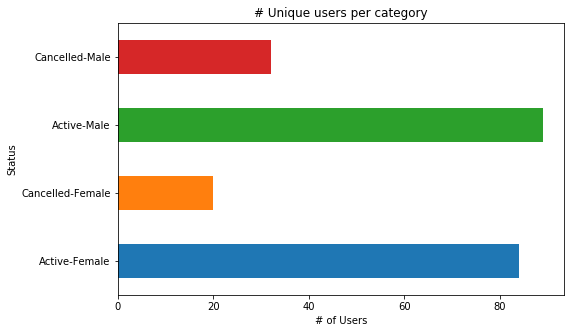

In [22]:
plot_demo_freq(['userId', 'gender'], 
               ['gender', 'churn'], 
               ['Active-Female', 'Cancelled-Female', 'Active-Male', 'Cancelled-Male'])

From this plot, we can see that male users have a higher number of both active and canel events. This could just be attributed to a higher number of male entries in the data set, though.

Let's take a look at the userAgent column:

In [23]:
pandas_df['userAgent'].value_counts()

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                                22751
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"                        19611
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                     18448
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                     17348
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                       16700
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                                15395
"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/53

It looks like we have a lot of unique values that are only unique because of valeus outside the base OS used. We can use some code to clean this up into columns that are more usable for us.

In [24]:
# strip excess characters from the strings
agents = [x.strip() for x  in pandas_df.userAgent.unique()] 
agents[:10:2]

['"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"',
 '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"',
 '"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"',
 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0',
 'Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0']

In [25]:
# Using regex to extract the relevant information in the parenthesis of the values
expression = '\(([^\)]*)\)'

# Print this list of all OS used
sorted(list(set([re.findall(
    expression, x)[0].split(';')[0].capitalize(
) for x  in agents])))

['Compatible',
 'Ipad',
 'Iphone',
 'Macintosh',
 'Windows nt 5.1',
 'Windows nt 6.0',
 'Windows nt 6.1',
 'Windows nt 6.2',
 'Windows nt 6.3',
 'X11']

In [26]:
# Now we create manual mappings for these values, for both the general and specific description of the OS used
general_mapper = {'Compatible': 'Windows',  'Ipad': 'Mac',  'Iphone': 'Mac',  
          'Macintosh': 'Mac',  'Windows nt 5.1': 'Windows',  
          'Windows nt 6.0': 'Windows',  'Windows nt 6.1': 'Windows',  
          'Windows nt 6.2': 'Windows',  'Windows nt 6.3': 'Windows',  
          'X11': 'Linux'}
specific_mapper = {'Compatible': 'Windows 7',  'Ipad': 'iPad',  'Iphone': 'iPhone',  
          'Macintosh': 'MacOS',  'Windows nt 5.1': 'Windows XP',  
          'Windows nt 6.0': 'Windows Vista',  'Windows nt 6.1': 'Windows 7',  
          'Windows nt 6.2': 'Windows 8.0',  'Windows nt 6.3': 'Windows 8.1',  
          'X11': 'Linux'}

In [27]:
# print the lists generated by applying our mappers
print(sorted(list(set([general_mapper[re.findall(expression, x)[0].split(';')[0].capitalize()] for x  in agents]))),
sorted(list(set([specific_mapper[re.findall(expression, x)[0].split(';')[0].capitalize()] for x  in agents]))))

['Linux', 'Mac', 'Windows'] ['Linux', 'MacOS', 'Windows 7', 'Windows 8.0', 'Windows 8.1', 'Windows Vista', 'Windows XP', 'iPad', 'iPhone']


In [28]:
# Now we create user-defiend functions that will perform them apping on our Spark dataframe
general_OS = udf(lambda x: general_mapper[re.findall(expression, x)[0].split(';')[0].capitalize()])
df = df.withColumn("general_OS", general_OS(df.userAgent))

specific_OS = udf(lambda x: specific_mapper[re.findall(expression, x)[0].split(';')[0].capitalize()])
df = df.withColumn("specific_OS", specific_OS(df.userAgent))

In [29]:
# redefine pandas DF
pandas_df = df.toPandas()

In [30]:
# check our new columns
pandas_df[['specific_OS', 'general_OS']].head()

,specific_OS,general_OS
0,iPhone,Mac
1,iPhone,Mac
2,iPhone,Mac
3,iPhone,Mac
4,iPhone,Mac


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [31]:
# Create a base df of jsut userIds and churn status
churn_df = df.select('userId', 'churn').dropDuplicates()

churn_df.show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [32]:
def create_dummies(col, mapper):
    
    col_df = df.select('userId', col).dropDuplicates().replace(mapper, subset=col)
    col_df = col_df.select('userId', col_df[col].cast('int'))
    
    print(col_df.printSchema(), col_df.show(5))
    return col_df

gender_df =  create_dummies('gender', {'M':'1', 'F':'0'})

root
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
+------+------+
only showing top 5 rows

None None


In [33]:
os_titles =  df.select('specific_os').distinct().rdd.flatMap(lambda x: x).collect()
os_expr = [sF.when(sF.col('specific_os') == osdt, 1).otherwise(0).alias("OS_" + osdt) for osdt in os_titles]
os_df = df.select('userId', *os_expr)
os_df.show(10)

+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|userId|OS_iPad|OS_iPhone|OS_Windows 8.1|OS_Linux|OS_Windows Vista|OS_Windows 8.0|OS_MacOS|OS_Windows XP|OS_Windows 7|
+------+-------+---------+--------------+--------+----------------+--------------+--------+-------------+------------+
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|    30|      0|        0|             0|       0|               0|             0|       0|            0|           1|
|     9|      0|        0|             0|       

In [34]:
# create dummy variables for the user tier
level_df = create_dummies('level', {'paid':'1', 'free':'0'})

root
 |-- userId: string (nullable = true)
 |-- level: integer (nullable = true)

+------+-----+
|userId|level|
+------+-----+
|100021|    0|
|200021|    0|
|200001|    0|
|     6|    0|
|300022|    1|
+------+-----+
only showing top 5 rows

None None


In [35]:
# Get song length per user per session
song_length = df.filter(df.page=='NextSong').select('userId', 'sessionId', 'length')
song_length = song_length.withColumn('hours', (song_length.length / 3600))
song_length = song_length.groupBy('userId', 'sessionId').sum('hours')
song_length = song_length.groupBy('userId').agg(
                        sF.avg('sum(hours)').alias('mean_hours'), 
                        sF.stddev('sum(hours)').alias('stdev_hours')).na.fill(0)
song_length.toPandas().head(10)

,userId,mean_hours,stdev_hours
0,100010,2.656385,1.594089
1,200002,4.352263,3.481087
2,125,0.580309,0.000000
3,51,14.535440,11.600663
4,124,10.042779,9.370878
5,7,1.509289,1.737257
6,54,5.645595,6.724164
7,15,9.470389,6.159368
8,155,9.202745,6.528672
9,100014,3.134420,1.754365


In [36]:
# Getting additional metrics
page_dist = df.groupby('userId').pivot('page').count().na.fill(0)
page_dist = page_dist.drop(*['Cancel','Cancellation Confirmation'])

page_cols = page_dist.columns[1:]

df2 = page_dist.withColumn('total', sum(page_dist[col] for col in page_cols))

for col in page_cols:
    df2 = df2.withColumn(f'norm_{col}', df2[col]/df2['total'] * 100.)
    
df2 = df2.drop('total')

df2 = df2.drop(*page_cols)

old_cols = df2.columns
new_cols = ['userId'] + page_cols

page_dist = reduce(lambda df2, idx: df2.withColumnRenamed(old_cols[idx], new_cols[idx]), range(len(old_cols)), df2)

# free up memory
df2 = None 

page_dist.toPandas().head(10)

,userId,About,Add Friend,Add to Playlist,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,0.632911,0.843882,1.687764,1.054852,0.000000,0.421941,4.219409,1.054852,81.645570,1.476793,0.000000,0.632911,0.000000,0.210970,1.265823,4.430380,0.421941
1,100010,0.262467,1.049869,1.837270,0.000000,0.000000,0.524934,2.887139,1.312336,72.178478,13.648294,0.000000,0.000000,0.000000,0.000000,1.312336,4.461942,0.524934
2,125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.888889,11.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,51,0.081235,1.137287,2.112104,0.934200,0.040617,0.487409,3.046304,0.974817,85.743298,0.000000,0.040617,0.487409,0.000000,0.000000,0.852965,4.061738,0.000000
4,124,0.145078,1.533679,2.445596,0.849741,0.124352,0.476684,3.647668,1.222798,84.538860,0.082902,0.124352,0.414508,0.000000,0.000000,0.849741,3.544041,0.000000
5,7,0.000000,0.497512,2.487562,0.000000,0.497512,0.497512,4.975124,1.492537,74.626866,7.960199,0.497512,1.492537,0.000000,0.000000,0.497512,3.482587,0.995025
6,54,0.145560,0.960699,2.096070,1.135371,0.029112,0.494905,3.755459,1.048035,82.707424,1.368268,0.087336,0.494905,0.029112,0.029112,0.844250,4.745269,0.029112
7,15,0.087796,1.360843,2.589991,1.229148,0.087796,0.351185,4.082529,1.185250,84.021071,0.043898,0.087796,0.702371,0.000000,0.000000,0.614574,3.555751,0.000000
8,155,0.199601,1.097804,2.395210,1.197605,0.299401,0.898204,2.994012,1.397206,81.836327,0.798403,0.000000,0.499002,0.000000,0.099800,0.299401,5.788423,0.199601
9,132,0.173611,1.779514,1.649306,0.824653,0.130208,0.694444,3.602431,1.475694,83.680556,0.086806,0.173611,0.737847,0.000000,0.043403,0.737847,4.166667,0.043403


In [37]:
song_user_df = df.filter(df.page == 'NextSong').groupBy(
                        'userId', 'sessionId').count()
song_user_df = song_user_df.groupBy('userId').agg(
                        sF.avg('count').alias('mean_songs'), 
                        sF.stddev('count').alias('stdev_songs'))
song_user_df = song_user_df.na.fill(0)

In [39]:
artists_user_fans = df.select('userId', 'artist').dropDuplicates().groupBy('userId').count().withColumnRenamed("count", "num_aritst")
artists_user_fans.show(5)

+------+----------+
|userId|num_aritst|
+------+----------+
|100010|       253|
|200002|       340|
|   125|         9|
|    51|      1386|
|   124|      2233|
+------+----------+
only showing top 5 rows



In [40]:
session_end = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed(
                                                            'max(ts)', 'end')
session_start = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed(
                                                            'min(ts)', 'start')
session_df = session_start.join(session_end,['userId', 'sessionId'])
ticks_per_hours = 1000 * 60 * 60
session_df = session_df.select('userId', 'sessionId', ((
    session_df.end-session_df.start)/ticks_per_hours).alias('session_hours'))
session_df.show(5)

+------+---------+-------------------+
|userId|sessionId|      session_hours|
+------+---------+-------------------+
|   101|      635| 55.000277777777775|
|   110|     1776| 1.3908333333333334|
|   120|      627| 15.855555555555556|
|   122|      691|0.30833333333333335|
|   140|      798|0.16027777777777777|
+------+---------+-------------------+
only showing top 5 rows



In [43]:
session_user_df = session_df.groupBy('userId').agg(
                        sF.avg('session_hours').alias('mean_session_h'), 
                        sF.stddev('session_hours').alias('stdev_session_h'))
# Fill NaN with 0
session_user_df = session_user_df.na.fill(0)
session_user_df.show(5)

+------+-------------------+------------------+
|userId|     mean_session_h|   stdev_session_h|
+------+-------------------+------------------+
|100010|  2.574722222222223|1.5888758093219746|
|200002|               4.44| 3.615756029749058|
|   125|0.49277777777777776|               0.0|
|    51| 14.539277777777775|11.671992558014606|
|   124|  9.649904214559387| 9.380928117286047|
+------+-------------------+------------------+
only showing top 5 rows



In [42]:
num_sessions_user_df = df.select('userId', 'sessionId').dropDuplicates().groupby('userId').count().withColumnRenamed('count', 'num_sessions')
num_sessions_user_df.show(5)

+------+------------+
|userId|num_sessions|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



In [44]:
def days_since_subscription(df, col_name='days_on'):
    reg_ts = df.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
    end_ts = df.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
    reg_df = reg_ts.join(end_ts,'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    reg_df = reg_df.select('userId', ((reg_df.end-reg_df.start)/ticks_per_day).alias(col_name))
    return reg_df

reg_df = days_since_subscription(df, col_name='days_total_subscription')
reg_df.show(5)

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
|   124|     131.55591435185184|
|    51|     19.455844907407407|
+------+-----------------------+
only showing top 5 rows



In [45]:
df_paid = df.filter(df.level=='paid')
paid_df = days_since_subscription(df_paid, col_name='days_paid_subscription')
paid_df.show(5)

+------+----------------------+
|userId|days_paid_subscription|
+------+----------------------+
|200002|     70.07462962962963|
|   124|    131.55591435185184|
|    51|    19.455844907407407|
|    15|    56.513576388888886|
|    54|    110.75168981481481|
+------+----------------------+
only showing top 5 rows



In [46]:
df_free = df.filter(df.level=='free')
free_df = days_since_subscription(df_free, col_name='days_free_subscription')
free_df.show(5)

+------+----------------------+
|userId|days_free_subscription|
+------+----------------------+
|100010|     55.64365740740741|
|200002|     41.49415509259259|
|   125|     71.31688657407408|
|     7|     72.77818287037037|
|    54|     96.45179398148149|
+------+----------------------+
only showing top 5 rows



In [47]:
paid_free_df = df.filter(df.page=='NextSong').groupBy('userId').pivot('level').count()
paid_free_df = paid_free_df.na.fill(0)
active_cols = paid_free_df.columns[1:]
paid_free_df = paid_free_df.withColumn('total', 
                                       sum(paid_free_df[col] for col in active_cols))
for col in active_cols:
    paid_free_df = paid_free_df.withColumn(f'{col}_percent', 
                                           paid_free_df[col] / paid_free_df.total * 100)
active_cols.append('total')    
paid_free_df = paid_free_df.drop(*active_cols)
paid_free_df.show(10)

+------+------------------+-----------------+
|userId|      free_percent|     paid_percent|
+------+------------------+-----------------+
|200002| 22.48062015503876|77.51937984496125|
|100010|             100.0|              0.0|
|   125|             100.0|              0.0|
|     7|             100.0|              0.0|
|   124|               0.0|            100.0|
|    51|               0.0|            100.0|
|    54|15.452305526223162|84.54769447377683|
|    15|               0.0|            100.0|
|   155|12.317073170731707| 87.6829268292683|
|   132|1.4522821576763485|98.54771784232366|
+------+------------------+-----------------+
only showing top 10 rows



In [48]:
paid_free_df = paid_free_df.drop('free_percent')
paid_free_df.show(3)

+------+-----------------+
|userId|     paid_percent|
+------+-----------------+
|200002|77.51937984496125|
|100010|              0.0|
|   125|              0.0|
+------+-----------------+
only showing top 3 rows



In [51]:
user_features = [gender_df, os_df, paid_free_df, song_length, 
                   page_dist, song_user_df, artists_user_fans, 
                   session_user_df, num_sessions_user_df, reg_df]
user_features_names = ['gender_df', 'os_df', 'paid_free_df', 'song_length', 
                   'page_dist', 'song_user_df', 'artists_user_fans', 
                   'session_user_df', 'num_sessions_user_df', 'reg_df']

In [53]:
final_df = churn_df

def join_features(base, new):
    df_to_join = new#.withColumnRenamed('userId', 't_userId')
    base = base.join(df_to_join, 'userId', how='inner')#.drop('t_userId')#.show(10)
    return base.dropDuplicates()

for i, feature in enumerate(user_features):
    print(f'Preparing features of the {user_features_names[i]} dataframe', end='; ')
    final_df = join_features(final_df, feature)
    print (f"the new frame's dimensions is: {final_df.count()} * {len(final_df.columns)}")
final_df = final_df.orderBy('userId', ascending=True)
print('*** ALL DONE ***')

Preparing features of the gender_df dataframe; the new frame's dimensions is: 225 * 3
Preparing features of the os_df dataframe; the new frame's dimensions is: 225 * 12
Preparing features of the paid_free_df dataframe; the new frame's dimensions is: 225 * 13
Preparing features of the song_length dataframe; the new frame's dimensions is: 225 * 15
Preparing features of the page_dist dataframe; the new frame's dimensions is: 225 * 32
Preparing features of the song_user_df dataframe; the new frame's dimensions is: 225 * 34
Preparing features of the artists_user_fans dataframe; the new frame's dimensions is: 225 * 35
Preparing features of the session_user_df dataframe; the new frame's dimensions is: 225 * 37
Preparing features of the num_sessions_user_df dataframe; the new frame's dimensions is: 225 * 38
Preparing features of the reg_df dataframe; the new frame's dimensions is: 225 * 39
*** ALL DONE ***


In [54]:
final_df.write.save('clean_dataset.CSV', format='csv', header=True)

In [55]:
final_dfp = final_df.toPandas()
final_dfp.head(10)

,userId,churn,gender,OS_iPad,OS_iPhone,OS_Windows 8.1,OS_Linux,OS_Windows Vista,OS_Windows 8.0,OS_MacOS,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_aritst,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,10,0,1,0,0,0,0,0,0,1,...,0.503145,4.654088,0.000000,112.166667,133.324291,566,7.662454,8.991061,6,51.762650
1,100,0,1,0,0,0,0,0,0,0,...,0.840075,4.604854,0.031114,78.882353,74.057621,1706,5.275317,5.133618,35,64.873773
2,100001,1,0,0,0,0,0,0,0,1,...,1.081081,4.324324,1.081081,33.250000,16.839933,126,2.469306,1.051126,4,44.800220
3,100002,0,0,0,0,0,0,0,0,0,...,0.000000,2.293578,0.000000,48.750000,84.428964,185,3.353056,5.901765,4,160.472072
4,100003,1,0,0,0,0,0,0,0,0,...,0.000000,3.947368,0.000000,25.500000,33.234019,51,1.651944,2.260385,2,22.748113
5,100004,0,0,0,0,0,0,0,0,0,...,0.883534,2.811245,0.642570,47.100000,55.459706,734,3.099775,3.895202,21,172.440081
6,100005,1,1,0,0,0,0,0,0,1,...,1.401869,3.271028,1.869159,38.500000,13.771952,150,2.003111,1.367039,5,85.195590
7,100006,1,0,0,0,1,0,0,0,0,...,4.761905,4.761905,0.000000,26.000000,0.000000,27,1.557222,0.000000,1,9.127164
8,100007,1,0,0,0,1,0,0,0,0,...,1.158301,3.667954,0.000000,47.000000,55.366958,358,3.156852,3.789902,9,115.387616
9,100008,0,0,0,0,0,0,0,0,1,...,0.638298,3.936170,0.425532,128.666667,182.128160,624,8.804213,12.541217,6,68.228565


In [56]:
final_dfp.to_csv('clean_dataset_pandas.CSV', index=False)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Since we went through the effort of saving out data set after building it, we can use the load function to load it here for modelling:

In [21]:
modelling_df = spark.read.csv('clean_dataset.CSV', header=True)
modelling_df_pandas = modelling_df.toPandas()

modelling_df_pandas.head()

,userId,churn,gender,OS_iPad,OS_iPhone,OS_Windows 8.1,OS_Linux,OS_Windows Vista,OS_Windows 8.0,OS_MacOS,...,Thumbs Down,Thumbs Up,Upgrade,mean_songs,stdev_songs,num_aritst,mean_session_h,stdev_session_h,num_sessions,days_total_subscription
0,30,0,1,0,0,0,0,0,0,0,...,0.9577464788732395,3.492957746478873,0.7887323943661971,50.607142857142854,68.92579976333879,1019,3.0599045138888887,4.655638231407505,32,63.06664351851852
1,300001,1,0,0,0,0,0,0,0,0,...,0.7848568790397045,6.832871652816251,0.09233610341643582,102.88235294117646,88.12908313444346,1202,6.367543859649123,6.150871757879998,19,188.3117824074074
2,91,0,1,0,0,1,0,0,0,0,...,0.7962840079628402,4.11413404114134,0.033178500331785,286.6666666666667,337.84426885770904,1619,19.665,23.019357929090734,9,116.02526620370371
3,92,0,0,1,0,0,0,0,0,0,...,0.9958506224066389,4.0387275242047025,0.06915629322268327,70.77380952380952,86.9796197137792,2905,4.745203488372092,6.054084867345142,86,83.52885416666666
4,200008,0,0,0,0,0,0,0,0,0,...,2.584493041749503,3.3797216699801194,0.049701789264413515,111.26666666666667,107.38613016763829,1160,7.5379259259259275,7.284556907097743,15,115.18381944444444


In [22]:
modelling_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- OS_iPad: string (nullable = true)
 |-- OS_iPhone: string (nullable = true)
 |-- OS_Windows 8.1: string (nullable = true)
 |-- OS_Linux: string (nullable = true)
 |-- OS_Windows Vista: string (nullable = true)
 |-- OS_Windows 8.0: string (nullable = true)
 |-- OS_MacOS: string (nullable = true)
 |-- OS_Windows XP: string (nullable = true)
 |-- OS_Windows 7: string (nullable = true)
 |-- paid_percent: string (nullable = true)
 |-- mean_hours: string (nullable = true)
 |-- stdev_hours: string (nullable = true)
 |-- About: string (nullable = true)
 |-- Add Friend: string (nullable = true)
 |-- Add to Playlist: string (nullable = true)
 |-- Downgrade: string (nullable = true)
 |-- Error: string (nullable = true)
 |-- Help: string (nullable = true)
 |-- Home: string (nullable = true)
 |-- Logout: string (nullable = true)
 |-- NextSong: string (nullable = true)
 |-- Roll 

Since having spaces in column names is a little inconvenient for us, let's replace the spaces with underscores:

In [23]:
for col in modelling_df.columns:
    modelling_df = modelling_df.withColumnRenamed(col, col.replace(' ', '_').replace('.', ''))

In [24]:
print(modelling_df.columns)

['userId', 'churn', 'gender', 'OS_iPad', 'OS_iPhone', 'OS_Windows_81', 'OS_Linux', 'OS_Windows_Vista', 'OS_Windows_80', 'OS_MacOS', 'OS_Windows_XP', 'OS_Windows_7', 'paid_percent', 'mean_hours', 'stdev_hours', 'About', 'Add_Friend', 'Add_to_Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll_Advert', 'Save_Settings', 'Settings', 'Submit_Downgrade', 'Submit_Upgrade', 'Thumbs_Down', 'Thumbs_Up', 'Upgrade', 'mean_songs', 'stdev_songs', 'num_aritst', 'mean_session_h', 'stdev_session_h', 'num_sessions', 'days_total_subscription']


We also need to make sure that all the column types are consistent. The schema shows that basically all the columns that should be either int or float are string type. Let's fix that:

In [25]:
# userId
modelling_df = modelling_df.withColumn('userId', modelling_df.userId.cast(sT.IntegerType()))

# from Churn to OS-type columns should be integers:
for col in modelling_df.columns[1:12]:
    modelling_df = modelling_df.withColumn(col, modelling_df[col].cast(sT.IntegerType()))

# the remaining columns should be floats:
for col in modelling_df.columns[12:]:
    modelling_df = modelling_df.withColumn(col, modelling_df[col].cast(sT.FloatType()))

In [26]:
# check to see if conversion was successful
modelling_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- OS_iPad: integer (nullable = true)
 |-- OS_iPhone: integer (nullable = true)
 |-- OS_Windows_81: integer (nullable = true)
 |-- OS_Linux: integer (nullable = true)
 |-- OS_Windows_Vista: integer (nullable = true)
 |-- OS_Windows_80: integer (nullable = true)
 |-- OS_MacOS: integer (nullable = true)
 |-- OS_Windows_XP: integer (nullable = true)
 |-- OS_Windows_7: integer (nullable = true)
 |-- paid_percent: float (nullable = true)
 |-- mean_hours: float (nullable = true)
 |-- stdev_hours: float (nullable = true)
 |-- About: float (nullable = true)
 |-- Add_Friend: float (nullable = true)
 |-- Add_to_Playlist: float (nullable = true)
 |-- Downgrade: float (nullable = true)
 |-- Error: float (nullable = true)
 |-- Help: float (nullable = true)
 |-- Home: float (nullable = true)
 |-- Logout: float (nullable = true)
 |-- NextSong: float (nullable = true)
 |-- Roll_Ad

In [27]:
# fill nulls
modelling_df = modelling_df.fillna(0)

In [28]:
# saving labels

# the reason we start from the 3rd column is because 0 is userid (which we can't use)
# and the 1 churn (our target variable)
feat_lab = modelling_df.columns[2:]

In [29]:
# vectorization of our data

feat_vec = VectorAssembler(inputCols=modelling_df.columns[2:], outputCol='features')

input_data = feat_vec.transform(modelling_df)

In [30]:
input_data.show(3)

+------+-----+------+-------+---------+-------------+--------+----------------+-------------+--------+-------------+------------+------------+----------+-----------+----------+----------+---------------+----------+-----------+----------+--------+---------+---------+-----------+-------------+----------+----------------+--------------+-----------+---------+---------+----------+-----------+----------+--------------+---------------+------------+-----------------------+--------------------+
|userId|churn|gender|OS_iPad|OS_iPhone|OS_Windows_81|OS_Linux|OS_Windows_Vista|OS_Windows_80|OS_MacOS|OS_Windows_XP|OS_Windows_7|paid_percent|mean_hours|stdev_hours|     About|Add_Friend|Add_to_Playlist| Downgrade|      Error|      Help|    Home|   Logout| NextSong|Roll_Advert|Save_Settings|  Settings|Submit_Downgrade|Submit_Upgrade|Thumbs_Down|Thumbs_Up|  Upgrade|mean_songs|stdev_songs|num_aritst|mean_session_h|stdev_session_h|num_sessions|days_total_subscription|            features|
+------+-----+----

In [31]:
# scale our data

scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')

scaler_fit = scaler.fit(input_data)
input_scaled = scaler_fit.transform(input_data)

In [32]:
# labelling our label and features
model_data = input_scaled.select(input_scaled.churn.alias('label'), input_scaled.scaled_features.alias('features'))

In [33]:
train, test = model_data.randomSplit([0.90, 0.10], seed=345)

Now that we've prepared our data to be fed into the model, let's define some functions that will streamline the modelling process when creating multiple models:

In [34]:
# prints how long a model takes to train/fit

def format_duration (t_diff):
    
    t_seconds = t_diff.seconds
    duration = {}
    duration['h'], remainder = divmod(t_seconds, 3600)
    duration['m'], duration['s'] = divmod(remainder, 60)
    stamp = ''
    
    if duration['h']>0:
        stamp += f"{duration['h']} hour(s), " 
    if duration['m']>0:
        stamp += f"{duration['m']} minute(s) and "
        
    frac = int(t_diff.microseconds/10000)/100
    stamp += f"{duration['s'] + frac} second(s)"
    return stamp

In [35]:
# function to fit model based on what type of model type and param grid we provide
def fit_model(data, model_type, param_grid, save_as, num_folds=5, random_seed=345):
    
    model_eval = CrossValidator(estimator=model_type, 
                                estimatorParamMaps=param_grid,
                                evaluator=MulticlassClassificationEvaluator(),
                                numFolds=num_folds,
                                seed=random_seed)
    
    time_start = pd.tslib.Timestamp.now()
    print("Currently fitting model...", end=" ")
    fitted_model = model_eval.fit(data)
    time_diff = pd.tslib.Timestamp.now() - time_start
    print("Done. Duration was: {}".format(format_duration(time_diff)))
    print("Saving model...")
    
    try:
        fitted_model.save(save_as)
    except:
        fitted_model.write().overwrite().save(save_as)
        print ('*Overwritten* ', end='')
        
    print("Saving complete")
    return fitted_model

In [36]:
# The outer function will format the results of the inner function
# The inner function will generate model metrics
def format_metrics(selected_model, test_data):

    def model_metrics(selected_model, model_type = 'train'):
        
        if model_type == 'train':
            metrics = selected_model.bestModel.summary
            
        else:
            metrics = selected_model
            
        acc = metrics.accuracy
        general = np.array((metrics.weightedFMeasure(),
                           metrics.weightedPrecision,
                           metrics.weightedRecall,
                           metrics.weightedTruePositiveRate,
                           metrics.weightedFalsePositiveRate))
        general = general.reshape(1, general.shape[0])
        labels = ['General'] + [f'Churn={x}' for x in metrics.labels]
        labelled = np.array((metrics.fMeasureByLabel(),
                            metrics.precisionByLabel,
                            metrics.recallByLabel,
                            metrics.truePositiveRateByLabel,
                            metrics.falsePositiveRateByLabel))
        concat_results = np.concatenate((general.T, labelled), axis=1)
        metrics_names = ['F-Measure', 'Precision', 'Recall', 'True_Pos_Rate', 'False_Pos_Rate']
        df_res = pd.DataFrame(concat_results, columns=labels, index=metrics_names)
        return acc, df_res

    acc_train, train_res = model_metrics(selected_model)
    model_test = selected_model.bestModel.evaluate(test_data)
    acc_test, test_res = model_metrics(model_test, model_type='test')
    
    cleaned_metrics = pd.concat([train_res, test_res], axis=1, keys=[
                    f'Training (Accuracy = {acc_train*100:4.2f}%)',
                    f'Testing (Accuracy = {acc_test*100:4.2f}%)'])
    
    return cleaned_metrics

In [37]:
# This function will plot the contribution of all the features in the model
def plot_feature_contributions(fitted_model, x_labels, scale_to="full_range"):
    
    coeff_matrix = fitted_model.bestModel.coefficientMatrix
    matrix_vals = coeff_matrix.values
    
    positive_vals = np.array([x if x>=0 else 0 for x in matrix_vals])
    negative_vals = np.array([x if x<=0 else 0 for x in matrix_vals])
    
    if scale_to == "full_range":
        r = positive_vals.sum()+ abs(negative_vals).sum()
    elif scale_to == "maximum_range":
        r = positive_vals.max()+ abs(negative_vals).max()
    else:
        r = 1
        
    positive_vals /= r
    negative_vals /= r
    positive_vals *= 100
    negative_vals *= 100
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.bar(x_labels, positive_vals,color='r')
    ax.bar(x_labels, negative_vals, color='g')
    ax.set_xlabel('Features')
    ax.set_ylabel('% Likelihood to Churn)')
    ax.set_title('Feature Contribution to churn decission')
    ax.set_xticklabels(labels = modelling_df.columns[2:], rotation='vertical');

In [38]:
def classifier_metrics(trained_model, train_data, test_data):
    
    def specific_metrics(trained_model, data):
        
        res2 = trained_model.transform(data).select('label', 'prediction')
        true_pos = res2.filter((res2.prediction==1) & (res2.label == res2.prediction) ).count()
        true_neg = res2.filter((res2.prediction==0) & (res2.label == res2.prediction) ).count()
        false_pos = res2.filter((res2.prediction==1) & (res2.label != res2.prediction) ).count()
        false_neg = res2.filter((res2.prediction==0) & (res2.label != res2.prediction) ).count()
        accuracy = res2.filter(res2.label == res2.prediction).count()/res2.count()
        precision = true_pos /(true_pos + false_pos)
        recall = true_pos/(true_pos + false_neg)
        f1 = (2 * precision * recall)/(precision + recall)
        
        return accuracy, precision, recall, f1
    
    train_metrics = specific_metrics(trained_model, train_data)
    test_metrics = specific_metrics(trained_model, test_data)
    label = ['Train', 'Test']
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
    metric_data = np.array((train_metrics, test_metrics))
    
    metric_df = pd.DataFrame(data=metric_data.T, columns=label, index=metric_labels)
    return metric_df

In [39]:
def feature_importance(fitted_model, x_labels, threshold=0.1):
    
    imp = list(fitted_model.bestModel.featureImportances.toArray())
    thresh_val = threshold/100
    
    active = [x for x in imp if x >= thresh_val]
    neglected = [x for x in imp if x < thresh_val]
    neglected_non_zero = [x for x in neglected if x > 0]
    
    active_index = [imp.index(x) for x in active]
    active_label = [x_labels[x] for x in active_index]
    
    minor_vals = sum(neglected)
    
    if minor_vals > 0:
        active.append(minor_vals)
        active_label.append(f'MINOR, ({len(neglected_non_zero)}feats. each<{threshold}%)')
        
    active_label =[x for _, x in sorted(zip(active, active_label))]
    active = sorted(active)
    
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.pie(active[::-1], labels=active_label[::-1] , 
           autopct='%1.1f%%', shadow=True, 
           startangle=90 )
    ax.set_title('Feature Importance for Churn Decision')
    ax.axis('equal');
    

Now that we have set up our essential functions, we can get around to modelling! For this project, we'll use two models: Logistic Regression and Random Forest:

### 1. Logistic Regression

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  # Remove the CWD from sys.path while we load stuff.


Currently fitting model... Done. Duration was: 4 minute(s) and 30.45 second(s)
Saving model...
*Overwritten* Saving complete


Training (Accuracy = 83.42%)                      \
                                    General Churn=0.0 Churn=1.0   
F-Measure                          0.814972  0.899083  0.535211   
Precision                          0.825219  0.844828  0.760000   
Recall                             0.834171  0.960784  0.413043   
True_Pos_Rate                      0.834171  0.960784  0.413043   
False_Pos_Rate                     0.460343  0.586957  0.039216   

               Testing (Accuracy = 73.08%)                      
                                   General Churn=0.0 Churn=1.0  
F-Measure                         0.649573  0.844444      0.00  
Precision                         0.584615  0.760000      0.00  
Recall                            0.730769  0.950000      0.00  
True_Pos_Rate                     0.730769  0.950000      0.00  
False_Pos_Rate                    0.780769  1.000000      0.05

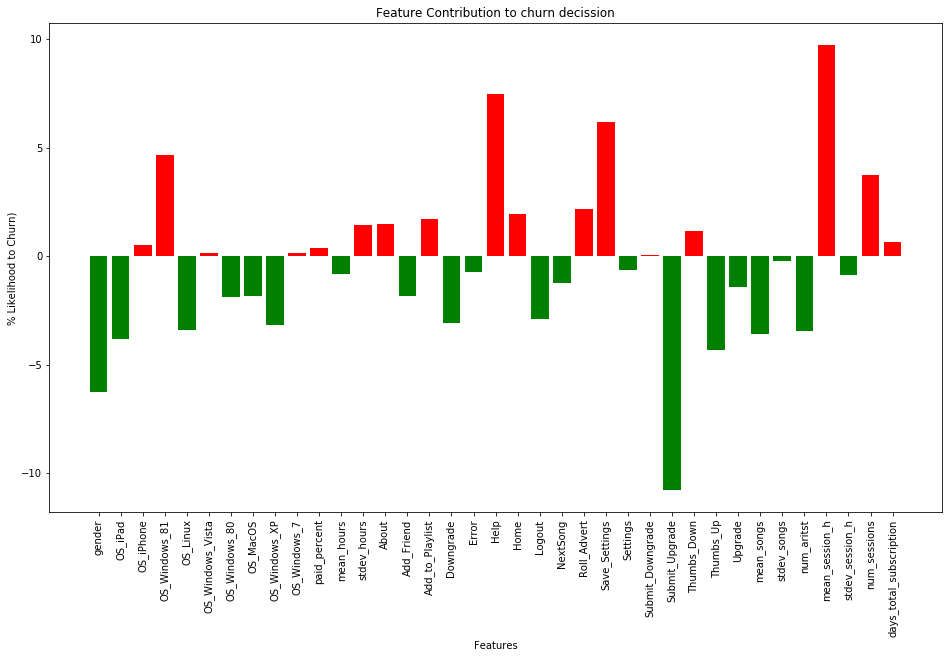

In [40]:
# Initialize the variables that we'll feed into our modelling functions

model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam, [0.01, 0.1]) \
    .addGrid(model.elasticNetParam, [0.0, 0.5]) \
    .addGrid(model.aggregationDepth, [2, 5]).build()

m = fit_model(train, model, param_grid, 'LogisticRegression.model')

display(format_metrics(m, test))

plot_feature_contributions(m, x_labels=feat_lab)

### 2. Random Forest

In [41]:
model = RandomForestClassifier()

param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth, [5, 10]) \
    .addGrid(model.impurity, ['entropy', 'gini']) \
    .addGrid(model.maxBins, [10, 5]) \
    .addGrid(model.numTrees, [20, 10]) \
    .addGrid(model.featureSubsetStrategy, ['sqrt', 'onethird']).build()

m = fit_model(train, model, param_grid, 'RandomForestClassifier.model')

Currently fitting model... Done. Duration was: 4 minute(s) and 42.92 second(s)
Saving model...
*Overwritten* Saving complete


In [42]:
display(classifier_metrics(m, train, test))

,Train,Test
Accuracy,0.984925,0.884615
Precision,1.000000,1.000000
Recall,0.934783,0.500000
F1_Score,0.966292,0.666667


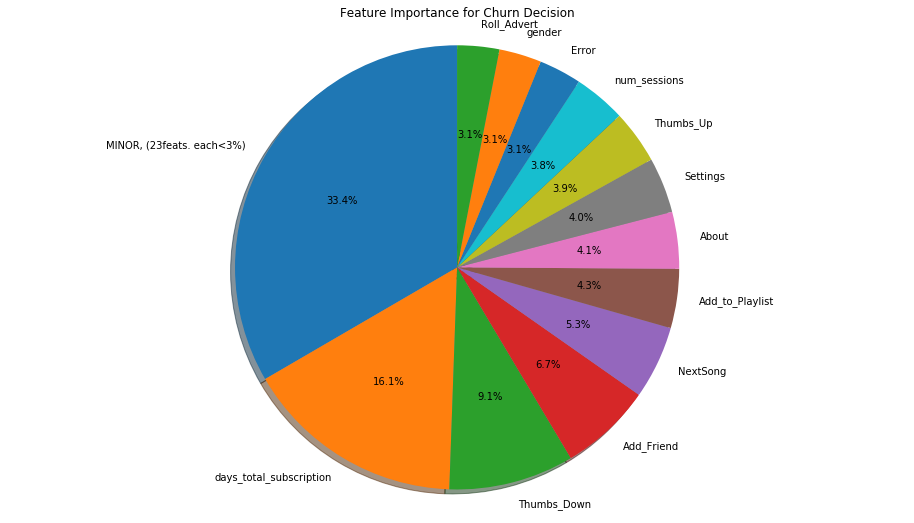

In [43]:
feature_importance(m, feat_lab, threshold=3)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.